<a href="https://colab.research.google.com/github/deva41103/PRODIGY_ML_03/blob/main/Deva3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import os
import cv2
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from google.colab import drive
from google.colab import files
from multiprocessing import Pool, cpu_count
from sklearn.decomposition import IncrementalPCA

drive.mount('/content/drive')

test_zip_path = '/content/drive/MyDrive/test1[2].zip'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test1')

def load_and_resize_image(img_path, img_size=(32, 32)):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, img_size)
    return img

def load_images_from_folder(folder, img_size=(32, 32)):
    img_paths = [os.path.join(folder, filename) for filename in os.listdir(folder)]

    with Pool(cpu_count()) as pool:
        images = pool.map(load_and_resize_image, img_paths)

    images = [img for img in images if img is not None]
    filenames = [os.path.basename(img_path) for img_path in img_paths if cv2.imread(img_path) is not None]
    return images, filenames

test_folder = '/content/test1/test1'
test_images, test_filenames = load_images_from_folder(test_folder)

X = np.array(test_images)

X = X / 255.0

X_flat = X.reshape(len(X), -1)

ipca = IncrementalPCA(n_components=None, batch_size=200)
X_ipca = ipca.fit_transform(X_flat)

n_components_selected = ipca.n_components_
print("Number of components selected:", n_components_selected)

np.random.seed(42)
y = np.random.randint(0, 2, size=len(X))

X_train, X_val, y_train, y_val = train_test_split(X_ipca, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_val_pred = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy}')
print(classification_report(y_val, y_val_pred))

test_predictions = svm_model.predict(X_ipca)

submission_df = pd.DataFrame({'id': test_filenames, 'label': test_predictions})
submission_df['id'] = submission_df['id'].str.extract('(\d+)').astype(int)
submission_df = submission_df.sort_values(by='id').reset_index(drop=True)
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of components selected: 200
Validation Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.51      0.48      0.49      1263
           1       0.50      0.53      0.51      1237

    accuracy                           0.50      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.50      0.50      0.50      2500



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Prediction for the image /content/test1/test1/1190.jpg: cat


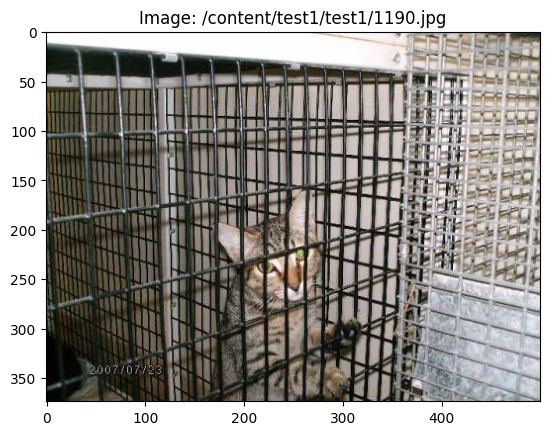

Prediction for the image /content/test1/test1/1190.jpg: cat


In [20]:
def predict_single_image(img_path, img_size=(32, 32)):
    img = load_and_resize_image(img_path, img_size)
    if img is not None:
        img = img / 255.0
        img_flat = img.flatten().reshape(1, -1)
        img_ipca = ipca.transform(img_flat)
        prediction = svm_model.predict(img_ipca)
        return prediction[0]
    return None

random_image_path = os.path.join(test_folder, test_filenames[0])  # You can choose any image from the test set

img = cv2.imread(random_image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f'Image: {random_image_path}')
plt.show()

prediction = predict_single_image(random_image_path)
print(f'Prediction for the image {random_image_path}: {"dog" if prediction == 1 else "cat"}')